In [ ]:
import sys
!{sys.executable} -m pip install -U -I --no-cache-dir git+https://github.com/jgraving/selfsne.git --user

In [1]:
# !killall python3
# !killall /usr/bin/python3

In [1]:
from __future__ import print_function

import numpy as np
np.set_printoptions(suppress=True)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import torch

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import gc
import joblib
from tqdm.autonotebook import tqdm
from scipy.special import expit 

import warnings

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import train_test_split
from kneed import KneeLocator

import selfsne
from selfsne import SelfSNE
from selfsne.noise import Normal
from selfsne.neighbors import NearestNeighborSampler

from selfsne.losses import DensityRatioEstimator
from selfsne.divergences import AlphaNCE, ForwardNCE, ReverseNCE
from selfsne.nn import MLP, ParametricResidual, init_selu, PairSampler, InputNorm1d
import selfsne.baselines as B
from selfsne.utils import Trainer, config_to_filename
from selfsne.data import TensorDataLoader
from selfsne.eval import knn_reconstruction, linear_reconstruction

from copy import deepcopy

In [2]:
seed_everything(1, workers=True)

Global seed set to 1


1


**Generating and Preprocessing the Swiss Roll Dataset**

In this cell, we:
1. Import the `make_swiss_roll` function to generate synthetic data resembling a Swiss roll.
2. Create training, validation, and test datasets with specified sample sizes.
3. Normalize the datasets to have a floating point data type.

In [3]:
DATASET = "swiss_roll_test"
DIR = "/media/nvme/"
x_train, train_labels = make_swiss_roll(60000, noise=0)
x_train = x_train.astype(np.float32)
x_val, val_labels = make_swiss_roll(10000, noise=0)
x_val = x_val.astype(np.float32)
x_test, test_labels = make_swiss_roll(10000, noise=0)
x_test = x_test.astype(np.float32)



**Visualizing the Swiss Roll Test Dataset in 3D**

This cell displays a 3D scatter plot of the test data (`x_test`). Each point's color is determined by its label (`test_labels`). The x, y, and z-axis limits are set to frame the data points optimally.


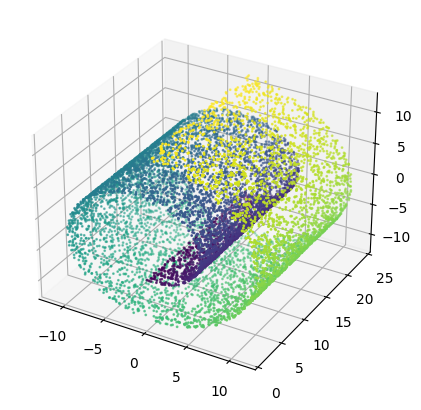

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_test[:, 0], x_test[:,1], x_test[:,2], c=test_labels, s=1)
ax.set_ylim(0, 25)
ax.set_xlim(-12.5, 12.5)
ax.set_zlim(-12.5, 12.5)
plt.show()


**Setup for Self-SNE Model Training and Testing**

This cell establishes the foundational settings, initialization functions, and configurations necessary for training and testing Self-SNE models:

1. **Basic Settings**:
    - `batch_size`: Number of samples per batch.
    - `embedding_dim`: Dimensions of the embedded space.
    - `input_dim`: Dimensionality of the input data.
    - `warmup_epochs`, `target_epochs`, `cosine_epochs`: Different epoch counts for various stages of training.
    - `hidden_dim`: Number of hidden units in neural layers.

2. **Encoder Initialization** (`init_encoder`):
    Initializes the neural network encoder for embedding data.

3. **Sampler Initializations**:
    - `init_augment_pair_sampler`: Creates a sampler that augments data.
    - `init_neighbor_pair_sampler`: Constructs a sampler based on nearest neighbors.
    - `SAMPLERS`: Dictionary mapping sampler names to their initialization functions.

4. **Model Initialization Functions**:
    - `init_similarity_model`: Sets up a Self-SNE model to train with a similarity-based loss.
    - `init_predict_model`: Configures a Self-SNE model for prediction.

5. **Training Environment Setup** (`init_trainer`):
    Specifies the training environment, like the GPU usage, precision, epochs, etc.

6. **Data Loading Functions**:
    - `init_loader`: Constructs a data loader for training.
    - `init_test_loader`: Creates a loader for testing.

The functions and configurations are modular to easily swap components or alter parameters during experiments.

In [5]:

batch_size = 1024
embedding_dim = 2
input_dim = 3
warmup_epochs = 10
target_epochs= 100
cosine_epochs = 100
max_epochs = warmup_epochs + target_epochs + cosine_epochs
hidden_dim = 1024

def init_encoder(embedding_dim, **kwargs):
    return nn.Sequential(
        InputNorm1d(input_dim),
        ParametricResidual(input_dim, hidden_dim, MLP(input_dim, hidden_dim, hidden_dim, num_layers=4)),
        init_selu(nn.Linear(hidden_dim, embedding_dim)),
    )

def init_augment_pair_sampler(input_dim):
    pair_sampler = PairSampler(x_sampler=Normal(scale=np.sqrt(input_dim)))
    return pair_sampler

def init_neighbor_pair_sampler(input_dim):
    pair_sampler = PairSampler(
        x_sampler=NearestNeighborSampler(input_dim, num_neighbors=1),
    )
    return pair_sampler

SAMPLERS = {"neighbor": init_neighbor_pair_sampler,
            "augment": init_augment_pair_sampler,}

def init_similarity_model(
    encoder,
    input_dim=input_dim,
    batch_size=batch_size,
    kernel="cauchy",
    divergence="kld",
    sampler="neighbor",
    kernel_scale=1,
    lr_scheduler=True,
    baseline="parametric",
):

    model = SelfSNE(
        encoder=encoder,
        encoder_x=deepcopy(encoder),
        pair_sampler=SAMPLERS[sampler](input_dim),
        similarity_loss=DensityRatioEstimator(
            kernel=kernel,
            divergence=divergence,
            kernel_scale=1,
            baseline=baseline,
            embedding_decay=0,
            temperature=1,
            symmetric_negatives=False,
        ),
        similarity_weight=1,
        learning_rate=3e-4,
        weight_decay=1e-5,
        optimizer="adam",
        lr_scheduler=lr_scheduler,
        lr_warmup_steps=warmup_epochs,
        lr_target_steps=target_epochs,
        lr_cosine_steps=cosine_epochs,
    )

    return model

def init_predict_model(
    encoder,
    projector=nn.Identity(),
):

    model = SelfSNE(encoder=encoder, projector=projector)

    return model


def init_trainer(
    gpus=[1],
    precision=32,
    max_epochs=max_epochs,
    limit_train_batches=1.0,
    enable_checkpointing=False,
    logger=False,
    verbose=True,
    callbacks=None,
    **kwargs
):
    return Trainer(
        accelerator="gpu",
        devices=gpus,
        precision=precision,
        max_epochs=max_epochs,
        limit_train_batches=limit_train_batches,
        enable_checkpointing=enable_checkpointing,
        enable_model_summary=False,
        logger=logger,
        deterministic=True,
        enable_progress_bar=verbose,
        callbacks=callbacks,
        # gradient_clip_val=1,
        **kwargs
    )


def init_loader(train, batch_size=batch_size):
    loader = TensorDataLoader(
        train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        device="cuda:1"
    )
    return loader


def init_test_loader(test, batch_size=1024, verbose=True):
    loader = DataLoader(
        test,
        batch_size=4096,
        shuffle=False,
        drop_last=False,
    )
    return loader

### Configurations for Alpha-NCE Sweep Experiment

In this cell, we're setting up configurations for an experiment that sweeps alpha for alpha-NCE

1. **Utility Function**:
   - We define a function to transform specific alpha values into their respective textual representations and objects.

2. **Divergences and Titles**:
   - We define different divergence types and their respective titles.
   - We define alpha values for alpha-NCE and derive their associated titles.

3. **alpha-NCE Configuration Generation**:
   - Configurations are generated for different embedding dimensions (1D, 2D, and 3D).
   - Each configuration is mapped to a filename, and we structure this data into a DataFrame.


In [6]:
def alphas_to_div_titles(alphas):
    alpha_objs = [AlphaNCE(alpha=alpha) for alpha in alphas]
    
    alpha_titles = []
    for alpha in alphas:
        alpha_titles.append(f"{alpha:.8}")
    return alpha_objs, alpha_titles

kl_div = ["kld", "jsd", "rkld"]
kl_div_titles = [
    "0\nKL",
    "0.5\nBCE/JS",
    "1\nRKL"
]
alphas = np.array([0.001, 0.01, 0.1, 0.25])
nce_alphas = np.sort(np.concatenate([alphas, 1 - alphas]))
alpha_nce, nce_titles = alphas_to_div_titles(nce_alphas)

divergences = kl_div + alpha_nce
div_titles = kl_div_titles + nce_titles

alpha_values = np.concatenate([[0, 0.5, 1], nce_alphas])
div_alpha = dict(zip(divergences, alpha_values))
div_title = dict(zip(divergences, div_titles))

inits = ["random"] 
baselines = [
    #"batch",
    #"batch_conditional",
    # "momentum",
    #"parametric_conditional",
    "parametric",
]
replicates = list(range(5))
samplers = ["augment"] 
kernels = ["precise_cauchy"]

configs_1d = [
    {
        "dataset": DATASET,
        "experiment": "nce_sweep",
        "idx": idx,
        "init": init,
        "kernel": kernel,
        "baseline": baseline,
        "divergence": divergence,
        "sampler": sampler,
        "embedding_dim": 1,
    }
    for idx in replicates
    for init in inits
    for kernel in kernels
    for baseline in baselines
    for divergence in kl_div + alpha_nce
    for sampler in samplers
]

configs_2d = [
    {
        "dataset": DATASET,
        "experiment": "nce_sweep",
        "idx": idx,
        "init": init,
        "kernel": kernel,
        "baseline": baseline,
        "divergence": divergence,
        "sampler": sampler,
        "embedding_dim": 2,
    }
    for idx in replicates
    for init in inits
    for kernel in kernels
    for baseline in baselines
    for divergence in kl_div + alpha_nce
    for sampler in samplers
]
configs_3d = [
    {
        "dataset": DATASET,
        "experiment": "nce_sweep",
        "idx": idx,
        "init": init,
        "kernel": kernel,
        "baseline": baseline,
        "divergence": divergence,
        "sampler": sampler,
        "embedding_dim": 3,
    }
    for idx in replicates
    for init in inits
    for kernel in kernels
    for baseline in baselines
    for divergence in kl_div + alpha_nce
    for sampler in samplers
]
configs = configs_1d + configs_2d + configs_3d
_ = [config.update({"filename": config_to_filename(config)}) for config in configs]
nce_config_df = pd.DataFrame(configs)
nce_config_df["alpha"] = nce_config_df["divergence"].map(div_alpha)
nce_config_df["div_title"] = nce_config_df["divergence"].map(div_title)
nce_config_df

,dataset,experiment,idx,init,kernel,baseline,divergence,sampler,embedding_dim,filename,alpha,div_title
0,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,kld,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.000,0\nKL
1,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,jsd,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.500,0.5\nBCE/JS
2,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,rkld,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,1.000,1\nRKL
3,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,"AlphaNCE(alpha=1.0e-03, k=1.0e-03, log_k=-6.9e...",augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.001,0.001
4,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,"AlphaNCE(alpha=1.0e-02, k=1.0e-02, log_k=-4.6e...",augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.010,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
160,swiss_roll_test,nce_sweep,4,random,precise_cauchy,parametric,"AlphaNCE(alpha=2.5e-01, k=3.3e-01, log_k=-1.1e...",augment,3,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.250,0.25
161,swiss_roll_test,nce_sweep,4,random,precise_cauchy,parametric,"AlphaNCE(alpha=7.5e-01, k=3.0e+00, log_k=1.1e+00)",augment,3,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.750,0.75
162,swiss_roll_test,nce_sweep,4,random,precise_cauchy,parametric,"AlphaNCE(alpha=9.0e-01, k=9.0e+00, log_k=2.2e+00)",augment,3,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.900,0.9
163,swiss_roll_test,nce_sweep,4,random,precise_cauchy,parametric,"AlphaNCE(alpha=9.9e-01, k=9.9e+01, log_k=4.6e+00)",augment,3,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.990,0.99


### Configurations for Embedding Dimension Sweep Experiment

In the subsequent cell, we set up configurations for an experiment that sweeps over embedding dimensions for KL, JS, and RKL:

1. **Divergence Definitions**:
   - We define key divergences like KL, JS, and RKL, along with their titles.

2. **Embedding Dimension Configuration Generation**:
   - Configurations are created based on combinations of embedding dimensions and the specified divergences.
   - As before, each configuration is mapped to a filename and structured into a DataFrame.


In [7]:
kl_div = ["kld", "jsd", "rkld"]
kl_div_titles = [
    "KL",
    "BCE/JS",
    "RKL"
]

divergences = kl_div
div_titles = kl_div_titles 

div_title = dict(zip(divergences, div_titles))

inits = ["random"] 
baselines = [
    #"batch",
    #"batch_conditional",
    #"momentum",
    #"parametric_conditional",
    "parametric",
]
replicates = np.arange(5)
samplers = ["augment"]
kernels = ["precise_cauchy"]
embedding_dims = np.arange(6) + 1
configs = [
    {
        "dataset": DATASET,
        "experiment": "dim_sweep",
        "idx": idx,
        "init": init,
        "kernel": kernel,
        "baseline": baseline,
        "divergence": divergence,
        "sampler": sampler,
        "embedding_dim": embedding_dim,
    }
    for idx in replicates
    for init in inits
    for kernel in kernels
    for baseline in baselines
    for divergence in kl_div
    for sampler in samplers
    for embedding_dim in list(embedding_dims) + [8, 16, 32, 128]
]
_ = [config.update({"filename": config_to_filename(config)}) for config in configs]
dim_config_df = pd.DataFrame(configs)
dim_config_df["alpha"] = dim_config_df["divergence"].map(div_alpha)
dim_config_df["div_title"] = dim_config_df["divergence"].map(div_title)

In [8]:

def init_model(divergence, kernel, baseline, sampler, embedding_dim):
    encoder = init_encoder(embedding_dim)

    if baseline == "parametric_conditional":
        bl = B.ConditionalBaseline(
            nn.Sequential(
                ParametricResidual(embedding_dim, hidden_dim, MLP(embedding_dim, hidden_dim, hidden_dim, num_layers=4)),
                init_selu(nn.Linear(hidden_dim, 1)),
            ),
            embedding_input=True,
            activation=nn.LogSigmoid(),
        )
    elif baseline == "parametric":
        bl = B.ParametricBaseline(1024)
    else:
        bl = baseline
    return init_similarity_model(
        encoder,
        lr_scheduler=True,
        divergence=divergence,
        sampler=sampler,
        kernel=kernel,
        baseline=bl,
    )
    

def train_embedding_model(dataset, divergence, init, kernel, baseline, idx, filename, sampler, embedding_dim, verbose=True, load_checkpoint=False):
    try:
        seed_everything(idx, workers=True)
        train_loader = init_loader(x_train)
        val_loader = init_loader(x_val)
        embedding_model = init_model(divergence, kernel, baseline, sampler, embedding_dim)
        embedding_trainer = init_trainer(verbose=verbose, check_val_every_n_epoch=10)
        if load_checkpoint:
            embedding_model = embedding_model.load_from_checkpoint(checkpoint_path=DIR + "checkpoints/" + filename + "_checkpoint.ckpt")
        embedding_trainer.fit(embedding_model, train_loader, val_loader)
        embedding_trainer.save_checkpoint(DIR + "checkpoints/" + filename + "_checkpoint.ckpt")
        torch.save(embedding_model.encoder, DIR + "checkpoints/" + filename + "_encoder.pt")
        del train_loader
        del embedding_model
        del embedding_trainer
        gc.collect()
        torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("Training process was interrupted by the user.")

def evaluate_embedding_model(dataset, divergence, init, kernel, baseline, idx, filename, sampler, embedding_dim, verbose=True):
    try:

        seed_everything(idx, workers=True)
        train_loader = init_loader(x_train)
        val_loader = init_loader(x_val)
        test_loader = init_loader(x_test)
        embedding_model = init_model(divergence, kernel, baseline, sampler, embedding_dim)
        embedding_trainer = init_trainer(verbose=verbose)
        embedding_model = embedding_model.load_from_checkpoint(checkpoint_path=DIR + "checkpoints/" + filename + "_checkpoint.ckpt")
        train_loss =  replace_prefix(embedding_trainer.validate(embedding_model, train_loader, verbose=verbose)[0])
        val_loss =  embedding_trainer.validate(embedding_model, val_loader, verbose=verbose)[0]
        test_loss =  embedding_trainer.test(embedding_model, test_loader, verbose=verbose)[0]
        del train_loader
        del embedding_model
        del embedding_trainer
        gc.collect()
        torch.cuda.empty_cache()
        return train_loss, val_loss, test_loss

    except KeyboardInterrupt:
        print("Training process was interrupted by the user.")

def replace_prefix(original_dict, old_prefix="val", new_prefix="train"):
    new_dict = {}

    for key, value in original_dict.items():
        new_key = key.replace(old_prefix, new_prefix)
        new_dict[new_key] = value

    return new_dict

def add_dict_to_dataframe(results_dict, idx, df):
    """
    Adds a dictionary of values to a specific row in a Pandas DataFrame.

    Parameters:
    results_dict (dict): A dictionary of column names and values to add to the DataFrame.
    idx (int): The index of the row in the DataFrame to update.
    df (pandas.DataFrame): The DataFrame to update.

    Returns:
    None
    """
    # update the specified row with the values from the dictionary
    for key, value in results_dict.items():
        df.loc[idx, key] = value

In [9]:
import logging
# configure logging at the root level of Lightning
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

In [10]:
# config_df = dim_config_df
# config_df = nce_config_df
config_df = pd.concat([nce_config_df, dim_config_df]).reset_index()


In [11]:
config_df

,index,dataset,experiment,idx,init,kernel,baseline,divergence,sampler,embedding_dim,filename,alpha,div_title
0,0,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,kld,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.000,0\nKL
1,1,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,jsd,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.500,0.5\nBCE/JS
2,2,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,rkld,augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,1.000,1\nRKL
3,3,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,"AlphaNCE(alpha=1.0e-03, k=1.0e-03, log_k=-6.9e...",augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.001,0.001
4,4,swiss_roll_test,nce_sweep,0,random,precise_cauchy,parametric,"AlphaNCE(alpha=1.0e-02, k=1.0e-02, log_k=-4.6e...",augment,1,dataset=swiss_roll_test|experiment=nce_sweep|i...,0.010,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,115,swiss_roll_test,dim_sweep,4,random,precise_cauchy,parametric,rkld,augment,6,dataset=swiss_roll_test|experiment=dim_sweep|i...,1.000,RKL
281,116,swiss_roll_test,dim_sweep,4,random,precise_cauchy,parametric,rkld,augment,8,dataset=swiss_roll_test|experiment=dim_sweep|i...,1.000,RKL
282,117,swiss_roll_test,dim_sweep,4,random,precise_cauchy,parametric,rkld,augment,16,dataset=swiss_roll_test|experiment=dim_sweep|i...,1.000,RKL
283,118,swiss_roll_test,dim_sweep,4,random,precise_cauchy,parametric,rkld,augment,32,dataset=swiss_roll_test|experiment=dim_sweep|i...,1.000,RKL


### Model Training

This cell is dedicated to the actual model training for the experiments based on the previously defined configurations:

- Using a progress bar (`tqdm`), we iterate through each configuration in the DataFrame.
- For every configuration, we:
    - Extract the relevant configuration attributes.
    - Attempt to train the embedding model using the extracted configuration.
- In case of any errors during the training process:
    - The error is raised, and a message is printed to indicate which configuration (based on its filename) failed.


In [12]:
# for idx, config in tqdm(config_df.iterrows(), total=config_df.shape[0]):
#     try:
#         config = config[["dataset", "divergence", "init", "kernel", "baseline", "idx", "filename", "sampler", "embedding_dim"]]
#         train_embedding_model(verbose=False, load_checkpoint=False, **config)
#     except Exception as e: 
#         raise e  
#         print(config["filename"] + " failed!")



### Model Evaluation

In this cell, we carry out the evaluation phase for our experiments:

- Iterating over each configuration in the DataFrame with the help of a progress bar (`tqdm`).
- For each configuration, the following steps are performed:
    - Relevant configuration attributes are extracted.
    - The embedding model's performance is evaluated, and loss values for training, validation, and testing phases are returned.
    - These loss values are then added to our DataFrame for future reference and analysis.
- If an error arises during the evaluation for a specific configuration:
    - The error is raised, and an indicative message mentions which configuration (based on its filename) encountered the issue.


In [ ]:
for idx, config in tqdm(config_df.iterrows(), total=config_df.shape[0]):
    try:
        config = config[["dataset", "divergence", "init", "kernel", "baseline", "idx", "filename", "sampler", "embedding_dim"]]
        train_loss, val_loss, test_loss = evaluate_embedding_model(verbose=False, **config)
        add_dict_to_dataframe(train_loss, idx, config_df)
        add_dict_to_dataframe(val_loss, idx, config_df)        
        add_dict_to_dataframe(test_loss, idx, config_df) 
    except Exception as e: 
        raise e  
        print(config["filename"] + " failed!")



### Embedding Prediction

This cell is responsible for the predictive phase of the embedding model:

1. **Function - predict_embedding_model**: 
    - Given a filename, this function loads the pre-trained encoder from the checkpoints.
    - Initializes loaders for training and testing datasets.
    - Creates a prediction model using the encoder and initiates a trainer.
    - Predictions (embeddings) for both training and testing datasets are then computed.
    - All associated resources, models, and loaders are freed from memory and GPU cache is cleared.

2. **Main Loop**:
    - We initialize empty lists to store the embeddings of the training and testing datasets.
    - Iterating over each configuration in our DataFrame, the following steps are executed:
        - The embedding prediction function is invoked using the configuration's filename.
        - The generated embeddings for training and testing datasets are appended to their respective lists.
    - In the event of an exception during prediction for a particular configuration, an error message indicates which configuration (by its filename) encountered the problem.

3. **Memory Management**:
    - After obtaining embeddings for all configurations, we ensure to release any lingering memory allocations using garbage collection and clearing the GPU cache.

4. **Update DataFrame**:
    - The DataFrame is then updated with the computed embeddings for both training and testing datasets. This ensures that all the information about each configuration, along with their corresponding embeddings, is stored in a single place for easy reference and further analysis.


In [14]:
def predict_embedding_model(filename, verbose=True):
    encoder = torch.load(DIR + "checkpoints/" + filename + "_encoder.pt")
    train_loader = init_test_loader(x_train, batch_size=4096)
    test_loader = init_test_loader(x_test, batch_size=4096)
    embedding_model = init_predict_model(encoder)
    embedding_trainer = init_trainer(verbose=verbose)
    train_results = embedding_trainer.predict(embedding_model, train_loader)
    test_results = embedding_trainer.predict(embedding_model, test_loader)
    del train_loader
    del test_loader
    del embedding_model
    del embedding_trainer
    gc.collect()
    torch.cuda.empty_cache()
    return train_results, test_results


In [15]:
train_embeddings = []
test_embeddings = []
for idx, config in tqdm(config_df.iterrows(), total=config_df.shape[0]):
    try:
        train_results, test_results = predict_embedding_model(config["filename"], verbose=False)
        train_embeddings.append(train_results["embedding"])
        test_embeddings.append(test_results["embedding"])
    except Exception as e:
        print(e)
        print(config["filename"] + " failed!")


gc.collect()
torch.cuda.empty_cache()

config_df["train_embedding"] = train_embeddings
config_df["test_embedding"] = test_embeddings



  0%|          | 0/285 [00:00<?, ?it/s]

### K-Nearest Neighbors (KNN) Reconstruction

In this cell, we perform a KNN reconstruction using the embeddings previously computed. The process unfolds as follows:

- We initialize empty lists to store R^2 scores for the training and testing datasets.
- For two values of `k` (1 and 10), the following actions occur within a loop:
    - Iterating over each configuration in our DataFrame:
        - We ensure consistent results by setting a seed.
        - Using the KNN reconstruction function, the R^2 scores are computed for the training and testing datasets using their respective embeddings.
    - The DataFrame is then updated with the computed R^2 scores for both datasets for the current value of `k`.

---

### Linear Reconstruction

Subsequently, in the next cell, we perform a linear reconstruction:

- Similarly, we initialize lists to store R^2 scores for the training and testing datasets.
- Iterating over each configuration in our DataFrame:
    - We ensure consistent results by setting a seed.
    - Using the linear reconstruction function, the R^2 scores are computed for the training and testing datasets.
- The DataFrame is updated with the R^2 scores for both the training and testing datasets.

By the end of these cells, the DataFrame contains the R^2 scores for both KNN and linear reconstructions, providing a comprehensive view of the model's performance across various configurations.


In [16]:
# for k in [1, 10]:
#     knn_r2_train = []
#     knn_r2_test = []
#     for idx, row in tqdm(config_df.iterrows(), total=config_df.shape[0]):
#         seed_everything(row["idx"], workers=True)
#         train_r2_score, test_r2_score = knn_reconstruction(
#             x_train, 
#             row["train_embedding"],
#             x_test,
#             row["test_embedding"],
#             nn.MSELoss(),
#             batch_size=1024,
#             k=k,
#             verbose=False
#         )
#         knn_r2_train.append(train_r2_score)
#         knn_r2_test.append(test_r2_score)

#     config_df[f"knn_r2_{k}_train"] = knn_r2_train
#     config_df[f"knn_r2_{k}_test"] = knn_r2_test

In [17]:
# linear_r2_train = []
# linear_r2_test = []
# for idx, row in tqdm(config_df.iterrows(), total=config_df.shape[0]):
#     seed_everything(row["idx"], workers=True)
#     train_r2_score, test_r2_score = linear_reconstruction(
#         x_train, 
#         row["train_embedding"],
#         x_test,
#         row["test_embedding"],  
#         nn.MSELoss(),
#         link=nn.Identity(), 
#         error=nn.MSELoss(), 
#         batch_size=1024,
#         lr=0.1, 
#         patience=5, 
#         tol=1e-2, 
#         verbose=False
#     )
#     linear_r2_train.append(train_r2_score)
#     linear_r2_test.append(test_r2_score)

# config_df[f"linear_r2_train"] = linear_r2_train
# config_df[f"linear_r2_test"] = linear_r2_test

### Saving and Loading the Results

In this section:

1. The DataFrame `config_df`, which contains results and configurations of previous experiments, is serialized and stored to disk using `joblib.dump`. This provides a persistent storage mechanism, enabling the ability to later reload results without having to re-run experiments.

2. Subsequently, the stored results are loaded back into the workspace using `joblib.load`.

3. Finally, we display the columns of the `config_df` DataFrame. This gives an overview of the available data fields, which can be crucial for subsequent analyses or visualizations.


In [50]:
# joblib.dump(config_df, DIR + "checkpoints/" + DATASET + "_" + "results.pkl")

['/media/nvme/checkpoints/swiss_roll_test_results.pkl']

In [26]:
config_df = joblib.load(DIR + "checkpoints/" + DATASET + "_" + "results.pkl")

In [27]:
config_df.columns 

Index(['index', 'dataset', 'experiment', 'idx', 'init', 'kernel', 'baseline',
       'divergence', 'sampler', 'embedding_dim', 'filename', 'alpha',
       'div_title', 'train_similarity', 'train_pos_logits', 'train_neg_logits',
       'train_kld', 'train_rkld', 'train_jsd', 'train_log_baseline',
       'train_pos_prob', 'train_neg_prob', 'train_accuracy', 'train_recall',
       'train_precision', 'train_loss', 'val_similarity', 'val_pos_logits',
       'val_neg_logits', 'val_kld', 'val_rkld', 'val_jsd', 'val_log_baseline',
       'val_pos_prob', 'val_neg_prob', 'val_accuracy', 'val_recall',
       'val_precision', 'val_loss', 'test_similarity', 'test_pos_logits',
       'test_neg_logits', 'test_kld', 'test_rkld', 'test_jsd',
       'test_log_baseline', 'test_pos_prob', 'test_neg_prob', 'test_accuracy',
       'test_recall', 'test_precision', 'test_loss', 'train_embedding',
       'test_embedding', 'knn_r2_1_train', 'knn_r2_10_train', 'knn_r2_1_test',
       'knn_r2_10_test', 'linear_r2

### Elbow Point Detection and Performance Across Dimensions

**Overview:**
This section is dedicated to detecting and visualizing the "elbow points" in the representation learning process as the embedding dimension is increased. An "elbow point" typically refers to a point in a curve where the trend changes direction, often representing an optimal value. In this case, we are examining the representation of data based on embedding dimension and various performance metrics.

**Detailed Breakdown:**

1. **Detecting Elbow Points:**
   - A new DataFrame `elbow_points_df` is initialized to store the detected elbow points.
   - A filtered DataFrame `elbow_df` is created which includes results from the specific dataset and experiment conditions defined.
   - For each unique divergence and replicate combination, the `KneeLocator` function is employed to detect the elbow point in the `train_similarity` versus `embedding_dim` curve.
   - Detected elbow points are added to `elbow_points_df`.

2. **Visualization:**
   - Multiple line plots are set up, one for each unique divergence metric ("KL", "JS", "RKL"), showcasing the relationship between embedding dimensions and various performance metrics (like lower bound, critic, accuracy, etc.).
   - For clarity, certain metrics, like `train_pos_logits` and `train_neg_logits`, are presented on the same axis with distinguishing colors.
   - Detected elbow points are overlaid as vertical dashed lines on each subplot to indicate the region where the trend changes.
   - Each subplot is labeled and formatted for better clarity and visualization.

3. **Saving the Visualizations:**
   - The created visualizations are saved to a specific path as a PDF file.


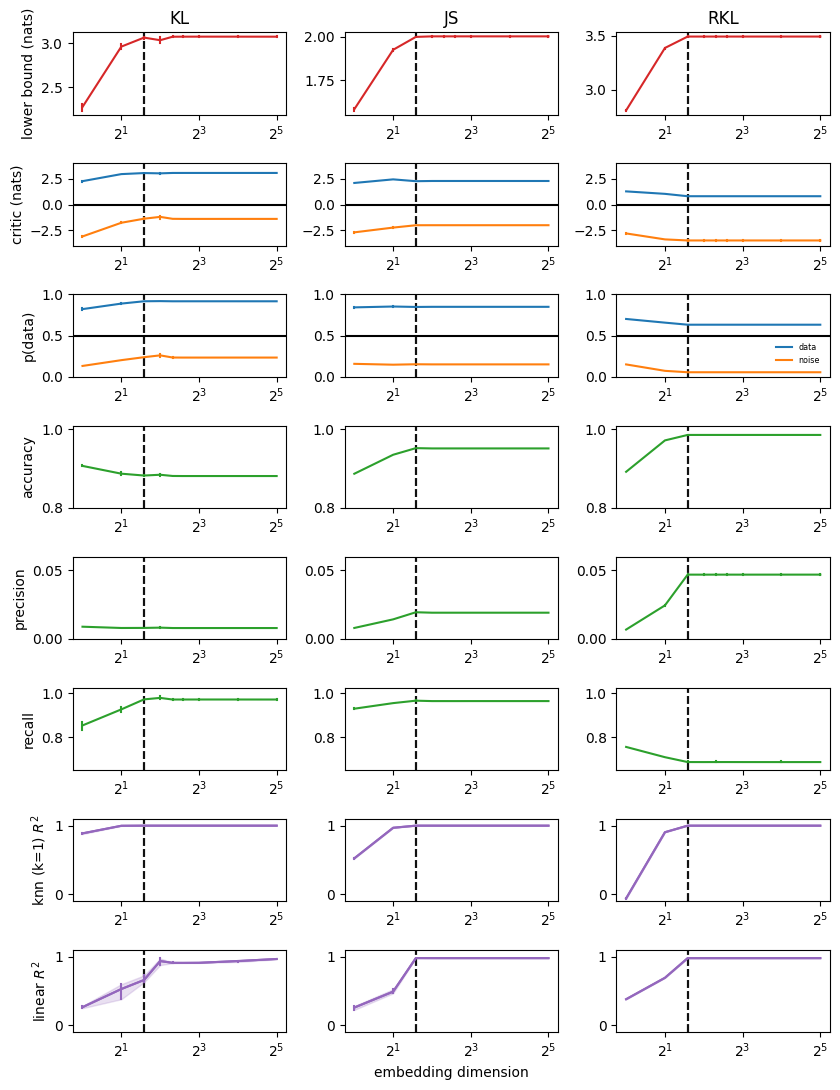

In [28]:

# assuming df is your DataFrame and it has columns 'embedding_dim', 'train_similarity', 'idx' and 'divergence'
# Create an empty DataFrame to hold the results
elbow_points_df = pd.DataFrame(columns=['divergence', 'idx', 'elbow_point'])
elbow_df = config_df[
        (config_df["dataset"] == DATASET)
        & (config_df["experiment"] == "dim_sweep")
        & (config_df["embedding_dim"] <= 128)
].copy()

# Loop over each divergence
for divergence in elbow_df['divergence'].unique():
    
    # Loop over each replicate
    for idx in elbow_df['idx'].unique():
        
        # Create a subset DataFrame for this divergence and replicate
        subset = elbow_df[(elbow_df['divergence'] == divergence) & (elbow_df['idx'] == idx)].sort_values(by='embedding_dim').copy()

        # Use KneeLocator to find the elbow point
        kn = KneeLocator(np.log(subset['embedding_dim']), np.exp(subset['train_similarity']), curve='convex', direction='decreasing', interp_method="polynomial", polynomial_degree=4)
        
        # Append the results to the DataFrame
        elbow_points_df = elbow_points_df.append({'divergence': divergence, 'idx': idx, 'elbow_point': np.exp(kn.knee)}, ignore_index=True)

elbow_points_df
divergences = ["kld", "jsd", "rkld"]
div_names = {"kld": "KL", "jsd": "JS", "rkld": "RKL"}
num_divergences = len(divergences)

# set up a figure with multiple subplots
fig, axes = plt.subplots(nrows=8, ncols=num_divergences, figsize=(8.5, 11))

lines_labels = []
for i, divergence in enumerate(divergences):
    ax = axes[:, i]

    plot_df = elbow_df[
        (elbow_df["dataset"] == DATASET) & 
        (elbow_df["divergence"] == divergence) & 
        (elbow_df["embedding_dim"] <= 32)
    ].copy()
    sns.lineplot(data=plot_df, x='embedding_dim', y=-plot_df['train_similarity'], ax=ax[0], err_style="bars", errorbar="pi", color="tab:red")

    sns.lineplot(data=plot_df, x='embedding_dim', y="train_pos_logits", ax=ax[1], err_style="bars", errorbar="pi", color="tab:blue", label='data')
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_neg_logits", ax=ax[1], err_style="bars", errorbar="pi", color="tab:orange", label='noise')
    ax[1].legend().remove()
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_pos_prob", ax=ax[2], err_style="bars", errorbar="pi", color="tab:blue", label='data')
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_neg_prob", ax=ax[2], err_style="bars", errorbar="pi", color="tab:orange", label='noise')
    ax[2].legend().remove()
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_accuracy", ax=ax[3], err_style="bars", errorbar="pi", color="tab:green")
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_precision", ax=ax[4], err_style="bars", errorbar="pi", color="tab:green")
    sns.lineplot(data=plot_df, x='embedding_dim', y="train_recall", ax=ax[5], err_style="bars", errorbar="pi", color="tab:green")
    sns.lineplot(x="embedding_dim", y="knn_r2_1_train", errorbar="pi", err_style="band", data=plot_df, ax=ax[6], color="tab:purple")
    sns.lineplot(x="embedding_dim", y="knn_r2_1_train", errorbar="pi", err_style="bars", data=plot_df, ax=ax[6], color="tab:purple")

    sns.lineplot(x="embedding_dim", y="linear_r2_train", errorbar="pi", err_style="band", data=plot_df, ax=ax[7], color="tab:purple")
    sns.lineplot(x="embedding_dim", y="linear_r2_train", errorbar="pi", err_style="bars", data=plot_df, ax=ax[7], color="tab:purple")

    ax[2].set_ylim(0, 1)
    for idx in range(len(ax)):
        # ax[idx].set_xticks(np.arange(6) + 1)
        ax[idx].set_ylabel("")
        ax[idx].set_xlabel("")
        ax[idx].set_xscale("log", base=2)

    ax[0].set_title(f"{div_names[divergence]}")
    ax[1].set_ylim(-4, 4)
    ax[1].axhline(0, linestyle='-', c='k')
    ax[2].axhline(0.5, linestyle='-', c='k')
    ax[3].set_ylim(0.8, 1.01)
    ax[4].set_ylim(0, 0.06)
    ax[5].set_ylim(0.65, 1.025)
    ax[6].set_ylim(-0.1, 1.1)
    ax[7].set_ylim(-0.1, 1.1)

    for _, row in elbow_points_df.iterrows():
        
        divergence = row['divergence']
        idx = row['idx']
        elbow_point = row['elbow_point']
        
        # Get the column index for this divergence
        i = divergences.index(divergence)
                    
        # Add a vertical line at the elbow point
        for j in range(len(axes)):
            axes[j, i].axvline(x=elbow_point, color='black', linestyle='dashed', alpha=0.2, zorder=-1)

axes[0, 0].set_ylabel("lower bound (nats)")
axes[1, 0].set_ylabel("critic (nats)")
axes[2, 0].set_ylabel("p(data)")
axes[3, 0].set_ylabel("accuracy")
axes[4, 0].set_ylabel("precision")
axes[5, 0].set_ylabel("recall")
axes[6, 0].set_ylabel(r"knn (k=1) $R^2$")
axes[7, 0].set_ylabel(r"linear $R^2$")

axes[-1, 1].set_xlabel("embedding dimension")
axes[2, 2].legend(fontsize="xx-small", loc="center", bbox_to_anchor=(0.85, 0.275), frameon=False)  # Create a legend for the second subplot

plt.tight_layout() 
plt.savefig("/home/jake/selfsne_figures/" + DATASET + "_dim.pdf")


### Visualization of Representation Learning Metrics for alpha-NCE

**Overview:**
This section visualizes various metrics related to representation learning as functions of the interpolation parameter, `alpha`. The `alpha` parameter interpolates between divergences which changes the attraction-repulsion ratio during training. 

**Detailed Breakdown:**

1. **Data Preparation:**
   - Selection of relevant data points from `config_df` based on the current dataset, experiment conditions, and embedding dimensions of interest.
   - Conversion of the `alpha` column to its logit representation, allowing it to span a wider range and better capture the nuances of very small or large values.
   
2. **Plotting Performance Metrics:**
   - The series of line plots are generated for the following metrics:
     - `Lower Bound`: The lower bound for each critic as `alpha` changes.
     - `Critic`: Measures the difference between data and noise in terms of logits, serving as a metric for the classifier's discriminative power.
     - `Probability`: Indicates the likelihood of data and noise, presented as probabilities.
     - `Accuracy`, `Precision`, and `Recall`: These are standard classification metrics indicating the performance of the critic.
     - `knn (k=1) R^2` and `linear R^2`: These metrics measure the quality of learned embeddings by examining their performance in k-nearest neighbors and linear regression tasks, respectively.
   
3. **Customizing Visuals:**
   - Seaborn's `lineplot` function is heavily utilized to create the line plots. This function provides the flexibility to show both confidence intervals (bands) and individual data points (bars).
   - Each subplot is equipped with custom labels to make the visualizations clearer and more intuitive.
   - Vertical reference lines are added to some subplots, like the `critic` and `probability` plots, to offer context for the displayed data.
   
4. **Finalizing the Visualization:**
   - Legends, which offer further clarity, are added selectively to avoid redundancy. These legends clarify the metrics, data/noise distinction, and embedding dimensions.
   - The visualization is saved to a specified path in PDF format for future reference and sharing.

5. **Displaying the Visualization:**
   - The combined plot is displayed in the Jupyter Notebook for a comprehensive understanding of the representation learning process across different metrics.

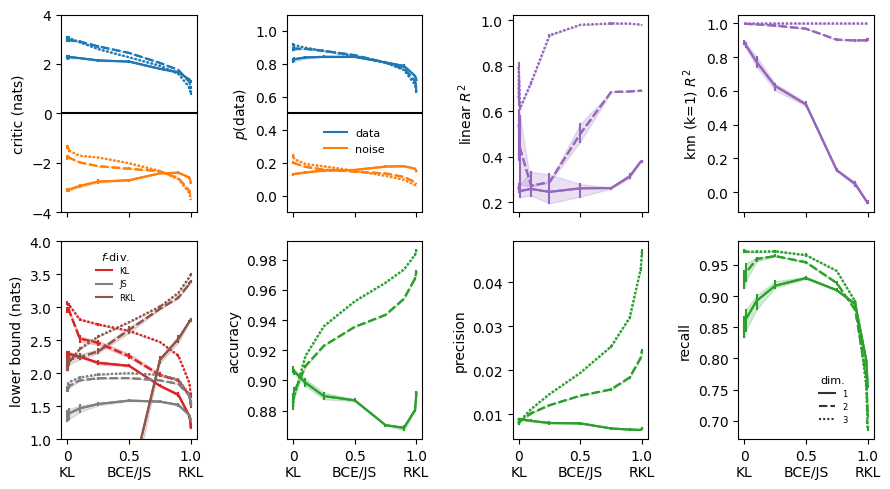

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logit

# Get colors from the 'tab10' colormap
colors = plt.get_cmap('tab10').colors

plot_df = config_df[(config_df["dataset"] == DATASET)
    & (config_df["baseline"] == "parametric") 
    & (config_df["experiment"] == "nce_sweep")
    & (config_df["embedding_dim"].isin([1, 2, 3]))
].copy()

plot_df["embedding_dim_str"] = plot_df["embedding_dim"].astype(str)

# Prepare your data
plot_df["alpha_logit"] = logit(plot_df["alpha"])

fig, ((ax0, ax1, ax6, ax5), (ax7, ax2, ax3, ax4)) = plt.subplots(2, 4, figsize=(9, 5), sharex=True)
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]  # Array of your axes for easy iteration
# Define new labels
new_labels = {0: '0\nKL', 0.5: '0.5\nBCE/JS', 1.0: '1.0\nRKL'}

# Set the xtick labels on all subplots
sns.lineplot(x="alpha", y=-plot_df["train_kld"], data=plot_df, ax=ax7, err_style="band", errorbar="pi", color="tab:red", style="embedding_dim_str", label="KL")
sns.lineplot(x="alpha", y=-plot_df["train_kld"], data=plot_df, ax=ax7, err_style="bars", errorbar="pi", color="tab:red", style="embedding_dim_str", label="KL")
sns.lineplot(x="alpha", y=-plot_df["train_jsd"], data=plot_df, ax=ax7, err_style="band", errorbar="pi", color="tab:gray", style="embedding_dim_str", label="JS")
sns.lineplot(x="alpha", y=-plot_df["train_jsd"], data=plot_df, ax=ax7, err_style="bars", errorbar="pi", color="tab:gray", style="embedding_dim_str", label="JS")
sns.lineplot(x="alpha", y=-plot_df["train_rkld"], data=plot_df, ax=ax7, err_style="band", errorbar="pi", color="tab:brown", style="embedding_dim_str", label="RKL")
sns.lineplot(x="alpha", y=-plot_df["train_rkld"], data=plot_df, ax=ax7, err_style="bars", errorbar="pi", color="tab:brown", style="embedding_dim_str", label="RKL")
ax7.legend(bbox_to_anchor=(0.65, 0.35), fontsize=6, frameon=False, loc="center")
ax7.set_ylabel("lower bound (nats)")
sns.lineplot(x="alpha", y="train_pos_logits", data=plot_df, ax=ax0, err_style="band", errorbar="pi", color="tab:blue", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_neg_logits", data=plot_df, ax=ax0, err_style="band", errorbar="pi", color="tab:orange", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_pos_logits", data=plot_df, ax=ax0, err_style="bars", errorbar="pi", color="tab:blue", label="data", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_neg_logits", data=plot_df, ax=ax0, err_style="bars", errorbar="pi", color="tab:orange", label="noise", style="embedding_dim_str")
ax0.axhline(0., linestyle='-', color='k')
ax0.set_ylabel("critic (nats)")
ax0.set_ylim(-4, 4)
sns.lineplot(x="alpha", y="train_pos_prob", data=plot_df, ax=ax1, err_style="band", errorbar="pi", color="tab:blue", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_neg_prob", data=plot_df, ax=ax1, err_style="band", errorbar="pi", color="tab:orange", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_pos_prob", data=plot_df, ax=ax1, err_style="bars", errorbar="pi", color="tab:blue", label='data', style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_neg_prob", data=plot_df, ax=ax1, err_style="bars", errorbar="pi", color="tab:orange", label='noise', style="embedding_dim_str")
ax1.axhline(0.5, linestyle='-', color='k')
ax1.set_ylabel(r"$p($data$)$")
ax1.set_ylim(-0.1, 1.1)
ax1.legend(bbox_to_anchor=(0.65, 0.35), fontsize=6, frameon=False, loc="center")  
sns.lineplot(x="alpha", y="train_accuracy", data=plot_df, ax=ax2, err_style="band", errorbar="pi", color="tab:green", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_accuracy", data=plot_df, ax=ax2, err_style="bars", errorbar="pi", color="tab:green", style="embedding_dim_str")
ax2.set_ylabel('accuracy')
sns.lineplot(x="alpha", y="train_precision", data=plot_df, ax=ax3, err_style="band", errorbar="pi", color="tab:green", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_precision", data=plot_df, ax=ax3, err_style="bars", errorbar="pi", color="tab:green", style="embedding_dim_str")
ax3.set_ylabel('precision')
sns.lineplot(x="alpha", y="train_recall", data=plot_df, ax=ax4, err_style="band", errorbar="pi", color="tab:green", style="embedding_dim_str")
sns.lineplot(x="alpha", y="train_recall", data=plot_df, ax=ax4, err_style="bars", errorbar="pi", color="tab:green", style="embedding_dim_str")
ax4.set_ylabel('recall')


sns.lineplot(x="alpha", y="knn_r2_1_train", errorbar="pi", err_style="band", data=plot_df, ax=ax5, style="embedding_dim_str", color="tab:purple")
sns.lineplot(x="alpha", y="knn_r2_1_train", errorbar="pi", err_style="bars", data=plot_df, ax=ax5, style="embedding_dim_str", color="tab:purple")

sns.lineplot(x="alpha", y="linear_r2_train", errorbar="pi", err_style="band", data=plot_df, ax=ax6, style="embedding_dim_str", color="tab:purple")
sns.lineplot(x="alpha", y="linear_r2_train", errorbar="pi", err_style="bars", data=plot_df, ax=ax6, style="embedding_dim_str", color="tab:purple")
for ax in axes:
    ax.get_legend().remove()  # remove individual legends
# Define custom labels, replace with your actual labels
#ax5.set_ylim(0.89, 1.01)
#ax6.set_ylim(0.18, 1.08)
ax5.set_ylabel(r"knn (k=1) $R^2$")
ax6.set_ylabel(r"linear $R^2$")
ax7.set_ylim(1.0, 4.0)

custom_labels = ["1", "2", "3"]
# Add a single legend to the figure
handles, labels = ax4.get_legend_handles_labels()  # We can take handles from any subplot, since they share the same legend
ax4.legend(handles=handles, labels=custom_labels, loc="center", bbox_to_anchor=(0.7, 0.2), title="dim.", fontsize=6, frameon=False, title_fontsize=8)  # Skipping first handle, as it's the legend title 'divergence'
custom_labels = ["KL", "JS", "RKL"]
# Add a single legend to the figure
handles, labels = ax7.get_legend_handles_labels()  # We can take handles from any subplot, since they share the same legend
ax7.legend(handles=[handles[0], handles[18], handles[24]], labels=custom_labels, loc="center", bbox_to_anchor=(0.4, 0.825), title=r"$f$-div.", fontsize=6, frameon=False, title_fontsize=8)  # Skipping first handle, as it's the legend title 'divergence'
 
custom_labels = ["data", "noise"]
# Add a single legend to the figure
handles, labels = ax1.get_legend_handles_labels()  # We can take handles from any subplot, since they share the same legend
ax1.legend(handles=[handles[6], handles[12]], labels=custom_labels, loc="center", bbox_to_anchor=(0.5, 0.36), fontsize=8, frameon=False)  # Skipping first handle, as it's the legend title 'divergence'
# handles, labels = ax0.get_legend_handles_labels()  # We can take handles from any subplot, since they share the same legend
# ax0.legend(handles=[handles[4], handles[8]], labels=custom_labels, loc="center", bbox_to_anchor=(0.7, 0.35), fontsize=6, frameon=False)  # Skipping first handle, as it's the legend title 'divergence'

for ax in axes:
    ax.set_xticks(list(new_labels.keys()))
    ax.set_xticklabels(list(new_labels.values()))
    ax.set_xlabel("")
plt.tight_layout()
plt.savefig("/home/jake/selfsne_figures/" + DATASET + "_nce_classifier.pdf")
plt.show()

### Embeddings Visualization for alpha-NCE

**Overview:**
This section focuses on visualizing 2d embeddings based on varying alpha-NCE values. The core concept is to represent each unique alpha value on a number line and then plot the corresponding embedding right above its position.

**Detailed Breakdown:**

1. **Initialization:**
   - The `plot_data` function is defined to facilitate the plotting process. By default, the type of plot is set to 'scatter', but it can be adjusted if needed.

2. **Setting the Canvas:**
   - The plotting canvas is initialized with dimensions 7.5x2.5 and a DPI of 600 for higher resolution. The borders and ticks are removed to provide an unobstructed view.
   - A black number line, ranging from 0 to 1, is plotted at the bottom. This serves as a reference for plotting the alpha values.

3. **Plotting Alpha Values:**
   - The unique alpha values are computed from the input `plot_df` DataFrame, evenly spaced between 0 and 1. Each alpha value is then represented as a black dot on the aforementioned number line.

4. **Embedding Visualization:**
   - For each row in the `plot_df` DataFrame, the corresponding embedding is retrieved. This embedding is then plotted as a scatter plot right above its respective alpha value on the number line.
   - A specialized inset axis is created for each embedding, ensuring consistent visualization and spacing.
   - Additional features like axis equalization, text labels, and other visual adjustments are applied to each inset axis for clarity.

5. **Final Plotting and Saving:**
   - A subset of the `config_df` DataFrame is filtered based on specific criteria (like dataset, baseline, index, embedding dimension, and experiment type) to create the `plot_df`.
   - The `plot_data` function is called with the newly created `plot_df` to visualize the embeddings.
   - The final visualization is saved as a PDF in a designated directory with a filename indicating the dataset and experiment type.

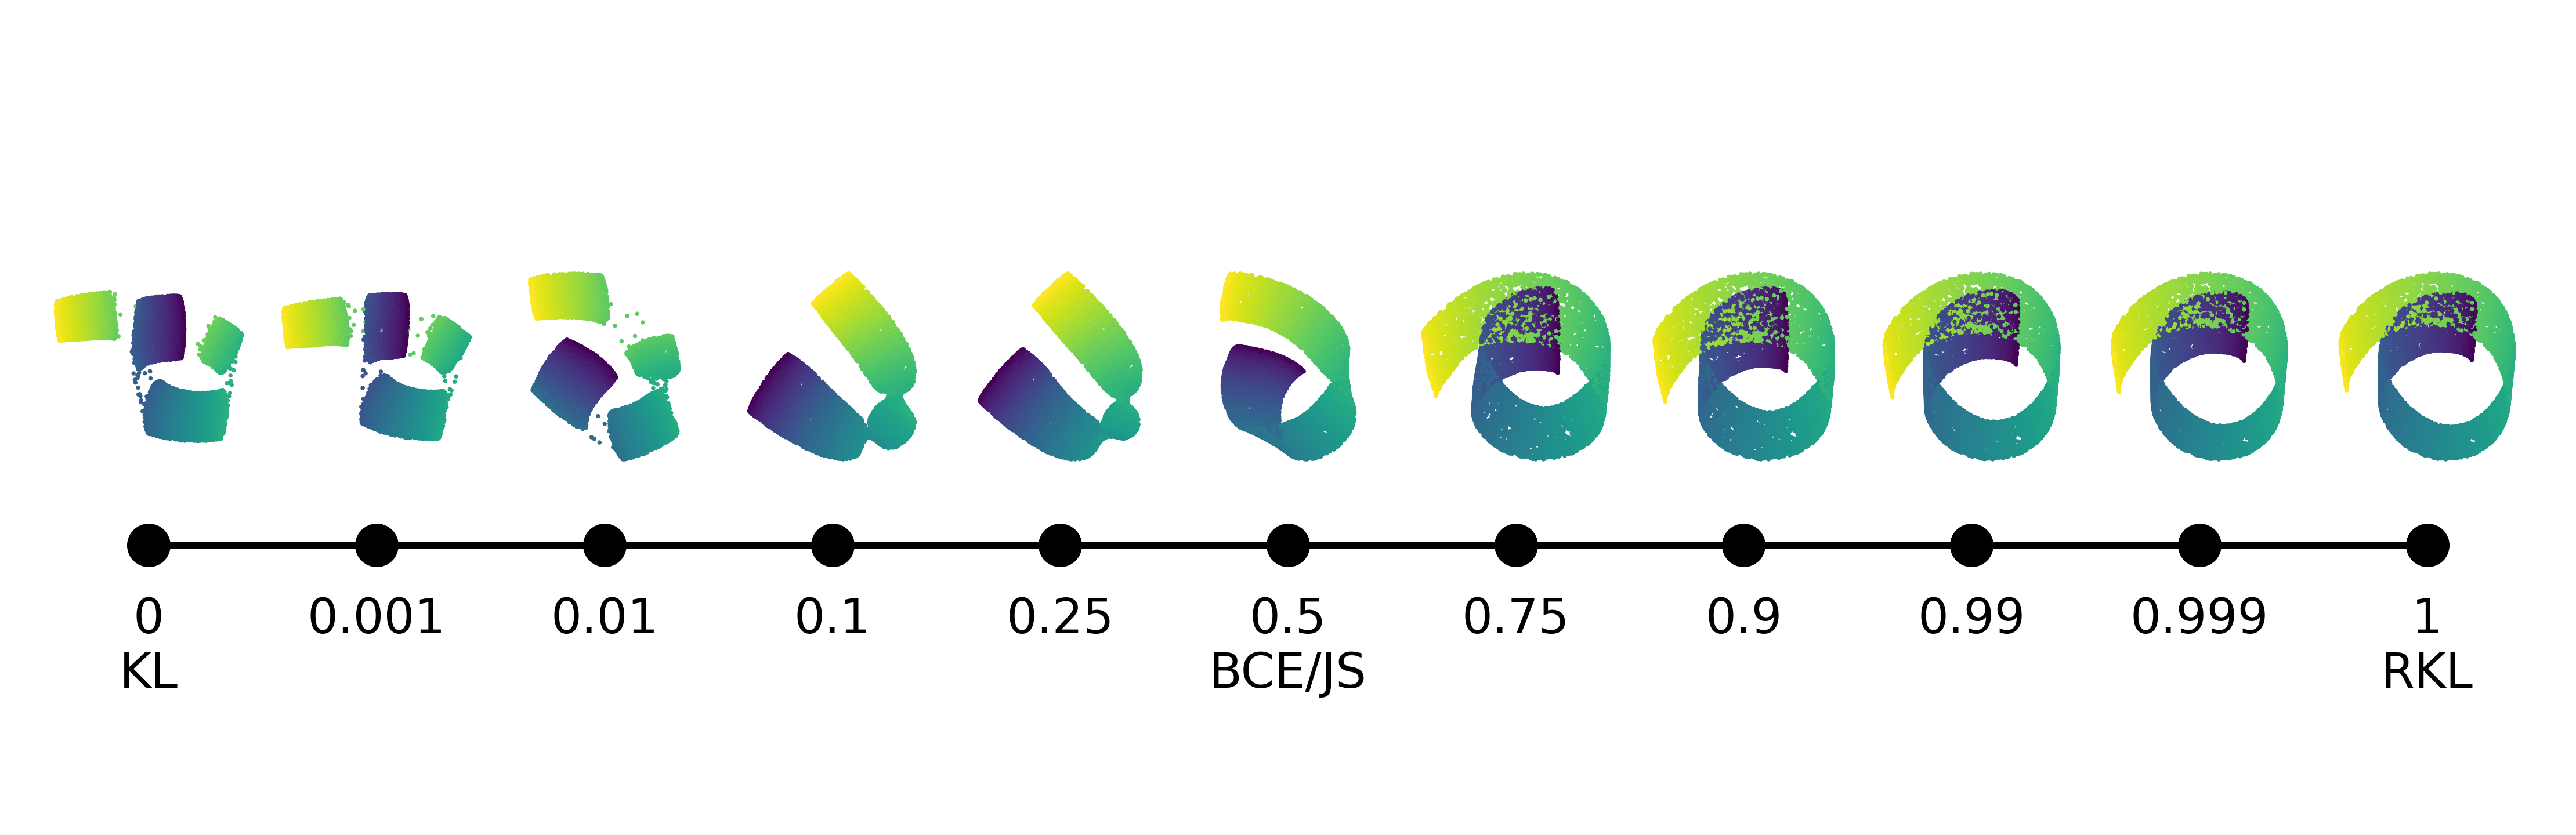

In [30]:
from selfsne.plot import equalize_axes_limits

def plot_data(plot_df, plot_type='scatter'):
    # Create a figure and axis with no visible borders or ticks
    fig, ax = plt.subplots(figsize=(7.5, 2.5), dpi=600)
    ax.axis('off')

    # Plot a black number line from 0 to 1
    ax.plot([0, 1], [0, 0], 'k-')

    # Plot points on the number line representing different values of alpha
    alpha_values = np.linspace(0, 1, plot_df["divergence"].unique().shape[0])
    for alpha in alpha_values:
        ax.plot(alpha, 0, 'ko', markersize=8)

    # Plot embeddings above each point on the number line
    for idx, (row_idx, row) in enumerate(plot_df.iterrows()):
        embedding = row["test_embedding"]
        alpha = alpha_values[idx]
        ax.set_ylim(-0.5, 1)
        ax_ = ax.inset_axes([alpha - 0.4 / 2, 0.15, 0.4, 0.4], transform=ax.transData)

        ax_.scatter(embedding[:, 0], embedding[:, 1], c=test_labels, cmap=plt.cm.viridis, s=0.8, alpha=1, edgecolors='none', rasterized=True)

        equalize_axes_limits(ax_)
        ax_.axis('off')
        ax_.set_aspect(1.)
        ax.text(alpha, -0.1, row["div_title"], fontsize=10, va="top", ha='center', transform=ax.transData)

    plt.tight_layout()
    return fig

plot_df = config_df[(config_df["dataset"] == DATASET)
    & (config_df["baseline"] == "parametric")
    & (config_df["idx"] == 2)
    & (config_df["embedding_dim"] == 2)
    & (config_df["experiment"] == "nce_sweep")

]
plot_df = plot_df.sort_values("alpha")
plot_df

plot_data(plot_df, "scatter")
plt.savefig("/home/jake/selfsne_figures/" + DATASET + "_nce_embedding_scatter.pdf")
plt.show()